# All imports #

In [26]:
from __future__ import print_function

import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn
import keras
import csv

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

from keras_uncertainty.models import MCDropoutClassifier, MCDropoutRegressor
from keras_uncertainty.utils import numpy_regression_nll


In [27]:
def load_joint_space_csv_chunks(file_path):
    data_frame = pd.read_csv(file_path, skiprows=1, header=None)
    del data_frame[18]
    return data_frame

def load_task_space_csv_chunks(file_path):
    return pd.read_csv(file_path, skiprows=1, header=None)


In [28]:
##please select the appropriate folder, willl use os.path.join() for completed script
TRAIN_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/'
TEST_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/test_4steps'

X_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_sysstate_q.csv')
x_train = load_task_space_csv_chunks(X_TRAIN_FILE)
q_train = load_joint_space_csv_chunks(Q_TRAIN_FILE)

X_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_sysstate_q.csv')
x_test = load_task_space_csv_chunks(X_TEST_FILE)
q_test = load_joint_space_csv_chunks(Q_TEST_FILE)

# Building the model with MC Droput #

In [29]:
"""
+/- based data splitting
We consider the Q features and use the feature with the highest SD for dividing the dataset. 
We consider all the positive values as IOD and all the negative values as OOD
"""

stats_x_train = pd.DataFrame()
stats_x_train["Mean"] = x_train.mean()
stats_x_train["Var"] = x_train.var()
stats_x_train["STD"] = x_train.std()
stats_x_train["OneSigmaMax"] = stats_x_train["Mean"] + stats_x_train["STD"]
stats_x_train["OneSigmaMin"] = stats_x_train["Mean"] - stats_x_train["STD"]
stats_x_train.T

max_std = stats_x_train["STD"].max()
colomn_max_std = stats_x_train["STD"].idxmax()

value = 0

InDistribution_Q_Train =  q_train[x_train[0] > value]
OutDistribution_Q_Train = q_train[x_train[0] < value]
InDistribution_X_Train =  x_train[x_train[0] > value]
OutDistribution_X_Train = x_train[x_train[0] < value]

InDistribution_Q_Test =  q_test[x_test[0] > value]
OutDistribution_Q_Test = q_test[x_test[0] < value]
InDistribution_X_Test =  x_test[x_test[0] > value]
OutDistribution_X_Test = x_test[x_test[0] < value]

x_train_1 = InDistribution_X_Train
q_train_1 = InDistribution_Q_Train
x_test_1 = InDistribution_X_Test
q_test_1 = InDistribution_Q_Test

OOD_x_train = OutDistribution_X_Train
OOD_q_train = OutDistribution_Q_Train
OOD_x_test = OutDistribution_X_Test
OOD_q_test = OutDistribution_Q_Test

print(x_train_1.shape, OOD_x_train.shape, x_test_1.shape, OOD_x_test.shape)
print(q_train_1.shape, OOD_q_train.shape, q_test_1.shape, OOD_q_test.shape)


(5226, 9) (10399, 9) (1485, 9) (2611, 9)
(5226, 18) (10399, 18) (1485, 18) (2611, 18)


In [30]:
print(x_train.shape, x_test.shape)

(15625, 9) (4096, 9)


In [31]:

x_scaler = MinMaxScaler()
q_scaler = MinMaxScaler()

#complete test set
x_train = x_scaler.fit_transform(x_train)
q_train = q_scaler.fit_transform(q_train)
x_test = x_scaler.transform(x_test)
q_test = q_scaler.transform(q_test)

#In order training set
x_train_1 = x_scaler.transform(x_train_1)
q_train_1 = q_scaler.transform(q_train_1)

IOD_x_train = x_train_1
IOD_q_train = q_train_1


#split testing data
IOD_x_test = x_scaler.transform(x_test_1)
IOD_q_test = q_scaler.transform(q_test_1)

OOD_x_test = x_scaler.transform(OOD_x_test)
OOD_q_test = q_scaler.transform(OOD_q_test)

In [121]:
dropoutRate = 0.2

In [122]:
def model_builder(input_shape, output_shape):
    def build_model(depth, width, reduction_factor):
        model = Sequential()

        for i in range(depth):
            num_neurons = max(int(width * (reduction_factor ** i)), 4)
            if i == 0:
                model.add(Dense(num_neurons, activation='relu', input_shape=(input_shape,)))
            else:
                model.add(Dropout(dropoutRate))
                model.add(Dense(num_neurons, activation='relu'))                

            model.add(BatchNormalization())

        model.add(Dense(output_shape, activation='sigmoid'))

        model.compile(loss='mse', optimizer='adam', metrics=["mae"])

        return model
    return build_model


In [123]:
HYPERPARAMETERS = {'depth': 6, 'width': 64, 'reduction_factor':  0.9}
with tf.device('/cpu:0'):
    model = model_builder(9, 18)(**HYPERPARAMETERS)
    hist = model.fit(x_train_1, q_train_1, epochs = 100, batch_size = 128, verbose = 1, validation_data=(IOD_x_test, IOD_q_test))

#use_multiprocessing=True, workers=1000

Train on 5226 samples, validate on 1485 samples
Epoch 1/100
5226/5226 [==============================] - 2s 338us/sample - loss: 0.1232 - mean_absolute_error: 0.2877 - val_loss: 0.1025 - val_mean_absolute_error: 0.2796
Epoch 2/100
5226/5226 [==============================] - 0s 48us/sample - loss: 0.0846 - mean_absolute_error: 0.2368 - val_loss: 0.0954 - val_mean_absolute_error: 0.2666
Epoch 3/100
5226/5226 [==============================] - 0s 53us/sample - loss: 0.0632 - mean_absolute_error: 0.2026 - val_loss: 0.0855 - val_mean_absolute_error: 0.2487
Epoch 4/100
5226/5226 [==============================] - 0s 52us/sample - loss: 0.0508 - mean_absolute_error: 0.1809 - val_loss: 0.0663 - val_mean_absolute_error: 0.2183
Epoch 5/100
5226/5226 [==============================] - 0s 53us/sample - loss: 0.0429 - mean_absolute_error: 0.1647 - val_loss: 0.0461 - val_mean_absolute_error: 0.1804
Epoch 6/100
5226/5226 [==============================] - 0s 54us/sample - loss: 0.0375 - mean_absolut

Epoch 49/100
5226/5226 [==============================] - 0s 53us/sample - loss: 0.0173 - mean_absolute_error: 0.1014 - val_loss: 0.0050 - val_mean_absolute_error: 0.0548
Epoch 50/100
5226/5226 [==============================] - 0s 53us/sample - loss: 0.0171 - mean_absolute_error: 0.1006 - val_loss: 0.0049 - val_mean_absolute_error: 0.0546
Epoch 51/100
5226/5226 [==============================] - 0s 54us/sample - loss: 0.0172 - mean_absolute_error: 0.1009 - val_loss: 0.0047 - val_mean_absolute_error: 0.0540
Epoch 52/100
5226/5226 [==============================] - 0s 54us/sample - loss: 0.0171 - mean_absolute_error: 0.1010 - val_loss: 0.0054 - val_mean_absolute_error: 0.0569
Epoch 53/100
5226/5226 [==============================] - 0s 56us/sample - loss: 0.0168 - mean_absolute_error: 0.0999 - val_loss: 0.0058 - val_mean_absolute_error: 0.0598
Epoch 54/100
5226/5226 [==============================] - 0s 54us/sample - loss: 0.0172 - mean_absolute_error: 0.1008 - val_loss: 0.0048 - val_me

Epoch 97/100
5226/5226 [==============================] - 0s 55us/sample - loss: 0.0145 - mean_absolute_error: 0.0918 - val_loss: 0.0041 - val_mean_absolute_error: 0.0490
Epoch 98/100
5226/5226 [==============================] - 0s 55us/sample - loss: 0.0143 - mean_absolute_error: 0.0917 - val_loss: 0.0039 - val_mean_absolute_error: 0.0479
Epoch 99/100
5226/5226 [==============================] - 0s 53us/sample - loss: 0.0146 - mean_absolute_error: 0.0924 - val_loss: 0.0042 - val_mean_absolute_error: 0.0495
Epoch 100/100
5226/5226 [==============================] - 0s 54us/sample - loss: 0.0144 - mean_absolute_error: 0.0919 - val_loss: 0.0039 - val_mean_absolute_error: 0.0476


In [124]:
q_pred = model.predict(x_test, verbose=0)
q_unnorm = q_scaler.inverse_transform(q_test)
q_pred_unnorm = q_scaler.inverse_transform(q_pred)

global_mae = mean_absolute_error(q_test, q_pred)
mae_1 = mean_absolute_error(q_unnorm, q_pred_unnorm)

print("Testing MAE: {:.5f}".format(global_mae))
print("Testing MAEX: {:.5f}".format(mae_1))

'''
# Compute MAE for each output independently.
for i in range(IOD_q_test.shape[1]):
    norm_mae_i = mean_absolute_error(IOD_q_test[:, i], q_pred[:, i])
    mae_i = mean_absolute_error(q_unnorm[:, i], q_pred_unnorm[:, i])
    print("Q feature {} has unnorm MAE: {:.4f} (Range {:.4f} to {:.4f}) normalized MAE: {:.4f}".format(i, mae_i, q_scaler.data_min_[i], q_scaler.data_max_[i], norm_mae_i))
'''

Testing MAE: 0.09037
Testing MAEX: 0.06336


'\n# Compute MAE for each output independently.\nfor i in range(IOD_q_test.shape[1]):\n    norm_mae_i = mean_absolute_error(IOD_q_test[:, i], q_pred[:, i])\n    mae_i = mean_absolute_error(q_unnorm[:, i], q_pred_unnorm[:, i])\n    print("Q feature {} has unnorm MAE: {:.4f} (Range {:.4f} to {:.4f}) normalized MAE: {:.4f}".format(i, mae_i, q_scaler.data_min_[i], q_scaler.data_max_[i], norm_mae_i))\n'

# MC Dropout Regressor, O/P : mean, Std #

In [125]:
def test_mcdropout_regressor(x_test_values, q_test_values, model, data_scaler):   
    mc_model = MCDropoutRegressor(model)
    inp = x_test_values  
    
    mean, std = mc_model.predict(inp, num_samples = 10)
    
    q_pred_unnormalised = data_scaler.inverse_transform(mean)
    
    #q_sd_unnromalised = data_scaler.inverse_transform(std)
    
    global_mae = mean_absolute_error(q_test_values, mean)

    print("Testing MAE: {:.5f}".format(global_mae))

    return q_pred_unnormalised, std
  


In [126]:

mean_1, std_1 = test_mcdropout_regressor(x_test, q_test, model, q_scaler)

q_test_unorm = q_scaler.inverse_transform(q_test)



Testing MAE: 0.29805


In [127]:
sd_test_1 = pd.DataFrame(std_1)

print(sd_test_1[0].min())

0.01151756


In [128]:
mean_test_IOD, sd_test_IOD = test_mcdropout_regressor(IOD_x_test, IOD_q_test, model, q_scaler)
q_test_unorm = q_scaler.inverse_transform(IOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_IOD, sd_test_IOD**2)))

Testing MAE: 0.22076
NLL: 2.45675


In [129]:
mean_test_OOD, sd_test_OOD = test_mcdropout_regressor(OOD_x_test, OOD_q_test, model, q_scaler)
q_test_unorm = q_scaler.inverse_transform(OOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_OOD, sd_test_OOD**2)))

Testing MAE: 0.27568
NLL: 16.82573


In [160]:
col_no = 2

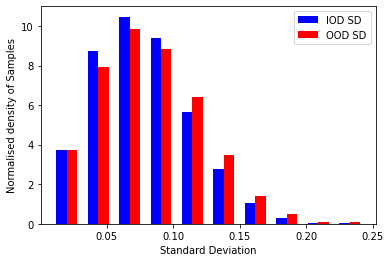

In [161]:
sd_test_IOD_df = pd.DataFrame(sd_test_IOD)
sd_test_OOD_df = pd.DataFrame(sd_test_OOD)
new_scores = np.concatenate([sd_test_IOD_df[col_no], sd_test_OOD_df[col_no]], axis=0)
minmaxscaler = MinMaxScaler()
new_scores_scaled = minmaxscaler.fit_transform(new_scores.reshape(-1, 1))
new_labels = np.concatenate([np.zeros_like(sd_test_IOD_df[col_no]), np.ones_like(sd_test_OOD_df[col_no])], axis=0)
histogram_df = pd.DataFrame(new_scores_scaled, new_labels)

#histogram_df.hist(column=0)

#sd_test_IOD_df.hist(column=0)
#sd_test_OOD_df.hist(column=0)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(sd_test_IOD_df[col_no].values.reshape(-1, 1), density=True)
b_heights, b_bins = np.histogram(sd_test_OOD_df[col_no].values.reshape(-1, 1), bins=a_bins, density=True)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width = width, facecolor='blue',label="IOD SD")
ax.bar(b_bins[:-1]+width, b_heights, width = width, facecolor='red', label="OOD SD")
ax.legend()
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Normalised density of Samples")
fig.savefig("density_vs_sd_dropout_neg_split_col_2.pdf")


In [162]:
print(sd_test_IOD.shape[1])

18


AUC Score:  0.5215618459586288


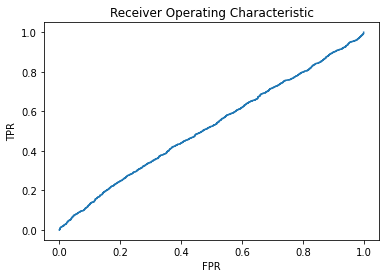

In [163]:
from sklearn.metrics import roc_curve, roc_auc_score
norm_scores = new_scores - min(new_scores) / (max(new_scores) - min(new_scores))

auc = roc_auc_score(new_labels, new_scores)
fpr, tpr, threshs = roc_curve(new_labels, norm_scores, drop_intermediate=True)
print("AUC Score: ",auc)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.savefig("auc_dropout_neg_split_col_2.pdf")
plt.show()
